<a href="https://colab.research.google.com/github/abdulrehman192/deepfake-detection/blob/master/deepfake2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connect with google drive for dataset

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Celeb-DF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np

# Function to extract skin imperfections (basic example)
def extract_skin_imperfections(image):
    # Convert the image to HSV color space for better skin color analysis
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for detecting skin color (you can adjust these)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a mask to extract skin color regions
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    # Find contours in the skin mask
    contours, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a count for skin imperfections
    imperfections_count = 0
    some_threshold = 0.5
    # Iterate through detected skin regions and check for imperfections
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > some_threshold:
            imperfections_count += 1

    return imperfections_count

In [ ]:
# histogram

def calculate_histogram_similarity(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)

In [ ]:
import os

def process_dataset(dataset_folder):
    all_features = []
    labels = []
    prev_hist = None
    similarity = None
    threshold = 0.1
    for class_name in ["real", "fake"]:
        class_folder = f'{dataset_folder}/{class_name}'
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            cap = cv2.VideoCapture(video_path)
            bit_rate = cap.get(cv2.CAP_PROP_BITRATE)
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                # Convert frame to HSV color space
                frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

                # Calculate histogram for the frame
                hist = cv2.calcHist([frame_hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

                # Normalize the histogram
                hist = cv2.normalize(hist, hist)

                if prev_hist is not None:
                    # Calculate histogram similarity between consecutive frames
                    similarity = calculate_histogram_similarity(prev_hist, hist)
                if similarity is None:
                  similarity = 0
                skin_imperfections = extract_skin_imperfections(frame)
                bitRate = np.array([bit_rate]);
                imperfections = np.array([skin_imperfections]);
                similarity = round(similarity, 3)
                similarity = np.array([similarity])
                feature_vector = np.concatenate((similarity, imperfections, bitRate))
                all_features.append(feature_vector)
                labels.append(class_name)
                prev_hist = hist

            cap.release()

    return np.array(all_features), labels

# Define your dataset paths
training_data, training_labels = process_dataset(os.path.join(dataset_path, 'training'))
testing_data, testing_labels = process_dataset(os.path.join(dataset_path, 'testing'))
#validation_data, validation_labels = process_dataset(os.path.join(dataset_path, 'validation'))




-----------------------Training Epoch Results--------------------

Epoch 1/5
12462/12462 [==============================] - 47s 4ms/step - loss: 0.2667 - accuracy: 0.9259
Epoch 2/5
12462/12462 [==============================] - 48s 4ms/step - loss: 0.2637 - accuracy: 0.9259
Epoch 3/5
12462/12462 [==============================] - 45s 4ms/step - loss: 0.2635 - accuracy: 0.9259
Epoch 4/5
12462/12462 [==============================] - 47s 4ms/step - loss: 0.2635 - accuracy: 0.9259
Epoch 5/5
12462/12462 [==============================] - 45s 4ms/step - loss: 0.2635 - accuracy: 0.9259

-----------------------Testing Epoch Results--------------------

Epoch 1/5
456/456 [==============================] - 2s 5ms/step - loss: 0.5622 - accuracy: 0.7474
Epoch 2/5
456/456 [==============================] - 2s 4ms/step - loss: 0.5551 - accuracy: 0.7474
Epoch 3/5
456/456 [==============================] - 2s 4ms/step - loss: 0.5516 - accuracy: 0.7474
Epoch 4/5
456/456 [=============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Precision: 0.0000
Training Recall: 0.0000
Training Accuracy: 0.9259
Training F1 Score: 0.0000
---------------------------
Testing Precision: 0.5000
Testing Recall: 0.1509
Testing Accuracy: 0.7474
Testing F1 Score: 0.2318

Confusion Matrix for Testing Data:
[[10329   555]
 [ 3124   555]]


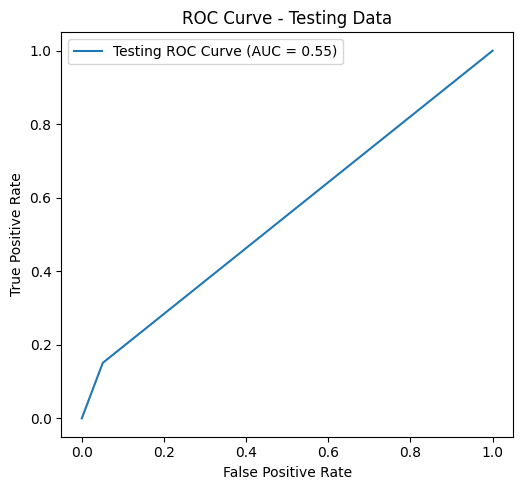

<Figure size 600x600 with 0 Axes>

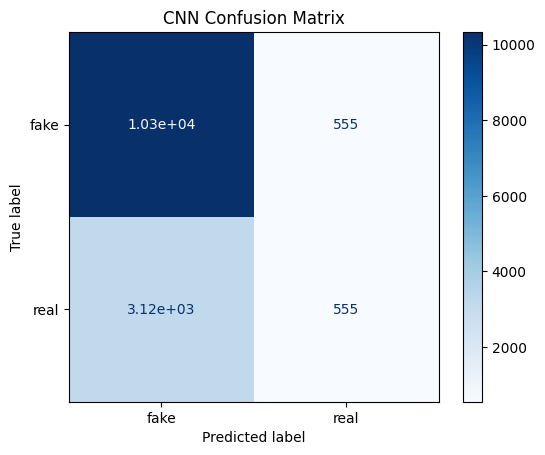

In [ ]:
# Step 2: Model Design and Training (CNN)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define input shape based on the number of features (3 in this case)
input_shape = (3,)

# Define and compile the CNN model
cnn_model = Sequential()
cnn_model.add(Dense(32, activation='relu', input_shape=input_shape))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Encode labels
label_encoder = LabelEncoder()
training_labels_encoded = label_encoder.fit_transform(training_labels)
testing_labels_encoded = label_encoder.fit_transform(testing_labels)
#validation_labels_encoded = label_encoder.fit_transform(validation_labels)


# Train the CNN model on your training, testing and validation data
print("")
print("-----------------------Training Epoch Results--------------------")
print("")
cnn_model.fit(np.array(training_data), np.array(training_labels_encoded), epochs=5, batch_size=32)
print("")
print("-----------------------Testing Epoch Results--------------------")
print("")
cnn_model.fit(np.array(testing_data), np.array(testing_labels_encoded), epochs=5, batch_size=32)
#print("")
#print("-----------------------Validation Epoch Results--------------------")
#print("")
#cnn_model.fit(np.array(validation_data), np.array(validation_labels_encoded), epochs=5, batch_size=32)

print("")
print("-----------------------CNN Model Evaluation--------------------")
print("")
# Evaluate the model on the training, testing and validation
training_loss, training_accuracy = cnn_model.evaluate(training_data, training_labels_encoded)
testing_loss, testing_accuracy = cnn_model.evaluate(testing_data, testing_labels_encoded)
#validation_loss, validation_accuracy = cnn_model.evaluate(validation_data, validation_labels_encoded)

#predict data

training_cnn_predictions = cnn_model.predict(training_data)
training_cnn_predictions = (training_cnn_predictions > 0.4).astype(int)
testing_cnn_predictions = cnn_model.predict(testing_data)
testing_cnn_predictions = (testing_cnn_predictions > 0.4).astype(int)
#validation_cnn_predictions = cnn_model.predict(validation_data)


# Calculate precision, recall, accuracy, and F1 score
training_precision = precision_score(training_labels_encoded, training_cnn_predictions.round())
training_recall = recall_score(training_labels_encoded, training_cnn_predictions.round())
training_accuracy = accuracy_score(training_labels_encoded, training_cnn_predictions.round())
training_f1_score = f1_score(training_labels_encoded, training_cnn_predictions.round())

testing_precision = precision_score(testing_labels_encoded, testing_cnn_predictions.round())
testing_recall = recall_score(testing_labels_encoded, testing_cnn_predictions.round())
testing_accuracy = accuracy_score(testing_labels_encoded, testing_cnn_predictions.round())
testing_f1_score = f1_score(testing_labels_encoded, testing_cnn_predictions.round())

print(f'Training Precision: {training_precision:.4f}')
print(f'Training Recall: {training_recall:.4f}')
print(f'Training Accuracy: {training_accuracy:.4f}')
print(f'Training F1 Score: {training_f1_score:.4f}')
print('---------------------------')
print(f'Testing Precision: {testing_precision:.4f}')
print(f'Testing Recall: {testing_recall:.4f}')
print(f'Testing Accuracy: {testing_accuracy:.4f}')
print(f'Testing F1 Score: {testing_f1_score:.4f}')

# Confusion Matrix
training_confusion_matrix = confusion_matrix(training_labels_encoded, training_cnn_predictions.round())
testing_confusion_matrix = confusion_matrix(testing_labels_encoded, testing_cnn_predictions.round())

print("")
print("Confusion Matrix for Testing Data:")
print(testing_confusion_matrix)

# ROC Curve
training_roc_auc = roc_auc_score(training_labels_encoded, training_cnn_predictions)
testing_roc_auc = roc_auc_score(testing_labels_encoded, testing_cnn_predictions)

fpr_train, tpr_train, _ = roc_curve(training_labels_encoded, training_cnn_predictions)
fpr_test, tpr_test, _ = roc_curve(testing_labels_encoded, testing_cnn_predictions)

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, label=f'Testing ROC Curve (AUC = {testing_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Data')
plt.legend()

plt.tight_layout()
plt.show()


cnn_confusion_matrix = confusion_matrix(testing_labels_encoded, testing_cnn_predictions.round())

# Display the CNN confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion_matrix, display_labels=np.unique(testing_labels))
disp.plot(cmap=plt.cm.Blues, values_format=".3g")
plt.title("CNN Confusion Matrix")
plt.show()

-----------------------Training Results--------------------

Epoch 1/5
12462/12462 [==============================] - 133s 11ms/step - loss: 0.2670 - accuracy: 0.9259
Epoch 2/5
12462/12462 [==============================] - 129s 10ms/step - loss: 0.2643 - accuracy: 0.9259
Epoch 3/5
12462/12462 [==============================] - 127s 10ms/step - loss: 0.2640 - accuracy: 0.9259
Epoch 4/5
12462/12462 [==============================] - 130s 10ms/step - loss: 0.2639 - accuracy: 0.9259
Epoch 5/5
12462/12462 [==============================] - 128s 10ms/step - loss: 0.2637 - accuracy: 0.9259

-----------------------Testing Results--------------------

Epoch 1/5
456/456 [==============================] - 4s 9ms/step - loss: 0.5662 - accuracy: 0.7474
Epoch 2/5
456/456 [==============================] - 5s 12ms/step - loss: 0.5611 - accuracy: 0.7474
Epoch 3/5
456/456 [==============================] - 5s 11ms/step - loss: 0.5606 - accuracy: 0.7474
Epoch 4/5
456/456 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Precision: 0.0000
Training Recall: 0.0000
Training Accuracy: 0.9259
Training F1 Score: 0.0000
---------------------------
Testing Precision: 0.0000
Testing Recall: 0.0000
Testing Accuracy: 0.7474
Testing F1 Score: 0.0000

Confusion Matrix for Training Data:
[[369236      0]
 [ 29538      0]]

Confusion Matrix for Testing Data:
[[10884     0]
 [ 3679     0]]


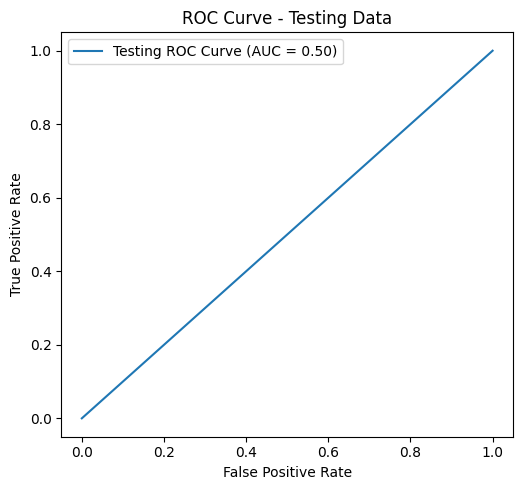

<Figure size 600x600 with 0 Axes>

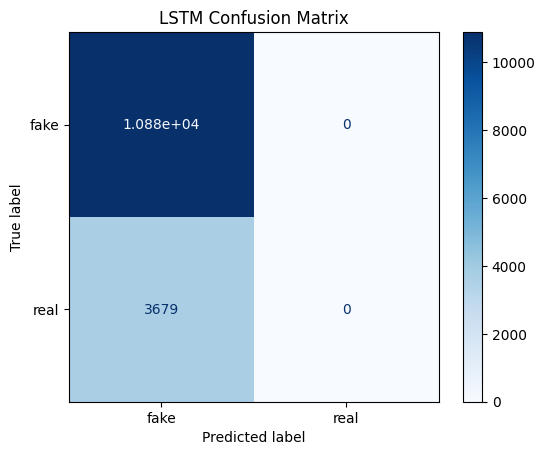

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import roc_auc_score


# Encode labels
label_encoder = LabelEncoder()
training_labels_encoded = label_encoder.fit_transform(training_labels)
testing_labels_encoded = label_encoder.transform(testing_labels)
#validation_labels_encoded = label_encoder.transform(validation_labels)

# Reshape the data for LSTM input
sequence_length_training = len(training_data[0])  # Use the length of your features
sequence_length_testing = len(testing_data[0])  # Use the length of your features
#sequence_length_validation = len(validation_data[0])  # Use the length of your features
training_data = np.array(training_data).reshape(-1, sequence_length_training, 1)
testing_data = np.array(testing_data).reshape(-1, sequence_length_testing, 1)
#validation_data = np.array(validation_data).reshape(-1, sequence_length_validation, 1)

# Define and compile the LSTM model
input_shape = (sequence_length_training, 1)
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=input_shape, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model on your training, testing and validation
print("-----------------------Training Results--------------------")
print("")
lstm_model.fit(training_data, training_labels_encoded, epochs=5, batch_size=32)
print("")
print("-----------------------Testing Results--------------------")
print("")
lstm_model.fit(testing_data, testing_labels_encoded, epochs=5, batch_size=32)
#print("-----------------------Validation Results--------------------")
#lstm_model.fit(validation_data, validation_labels_encoded, epochs=5, batch_size=32)

print("-----------------------Model Evaluation--------------------")
print("")
# Evaluate the model on the testing data
training_loss, training_accuracy = lstm_model.evaluate(training_data, training_labels_encoded)
testing_loss, testing_accuracy = lstm_model.evaluate(testing_data, testing_labels_encoded)
#validation_loss, validation_accuracy = lstm_model.evaluate(validation_data, validation_labels_encoded)

#predict data

training_lstm_predictions = lstm_model.predict(training_data)
training_lstm_predictions = (training_lstm_predictions > 0.5).astype(int)
testing_lstm_predictions = lstm_model.predict(testing_data)
testing_lstm_predictions = (testing_lstm_predictions > 0.5).astype(int)
#validation_lstm_predictions = lstm_model.predict(validation_data)

# Calculate precision, recall, accuracy, and F1 score
training_precision = precision_score(training_labels_encoded, training_lstm_predictions.round())
training_recall = recall_score(training_labels_encoded, training_lstm_predictions.round())
training_accuracy = accuracy_score(training_labels_encoded, training_lstm_predictions.round())
training_f1_score = f1_score(training_labels_encoded, training_lstm_predictions.round())

testing_precision = precision_score(testing_labels_encoded, testing_lstm_predictions.round())
testing_recall = recall_score(testing_labels_encoded, testing_lstm_predictions.round())
testing_accuracy = accuracy_score(testing_labels_encoded, testing_lstm_predictions.round())
testing_f1_score = f1_score(testing_labels_encoded, testing_lstm_predictions.round())

print(f'Training Precision: {training_precision:.4f}')
print(f'Training Recall: {training_recall:.4f}')
print(f'Training Accuracy: {training_accuracy:.4f}')
print(f'Training F1 Score: {training_f1_score:.4f}')
print('---------------------------')
print(f'Testing Precision: {testing_precision:.4f}')
print(f'Testing Recall: {testing_recall:.4f}')
print(f'Testing Accuracy: {testing_accuracy:.4f}')
print(f'Testing F1 Score: {testing_f1_score:.4f}')

# Confusion Matrix
training_confusion_matrix = confusion_matrix(training_labels_encoded, training_lstm_predictions.round())
testing_confusion_matrix = confusion_matrix(testing_labels_encoded, testing_lstm_predictions.round())

print("")
print("Confusion Matrix for Training Data:")
print(training_confusion_matrix)
print("")
print("Confusion Matrix for Testing Data:")
print(testing_confusion_matrix)

# ROC Curve
training_roc_auc = roc_auc_score(training_labels_encoded, training_lstm_predictions)
testing_roc_auc = roc_auc_score(testing_labels_encoded, testing_lstm_predictions)

fpr_train, tpr_train, _ = roc_curve(training_labels_encoded, training_lstm_predictions)
fpr_test, tpr_test, _ = roc_curve(testing_labels_encoded, testing_lstm_predictions)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, label=f'Testing ROC Curve (AUC = {testing_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Data')
plt.legend()

plt.tight_layout()
plt.show()

# Display the LSTM confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=testing_confusion_matrix, display_labels=np.unique(testing_labels_encoded))
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("LSTM Confusion Matrix")
plt.show()


-----------------------Hybrid Model Training--------------------------

-----------------------Training Epoch Results--------------------------

Epoch 1/3
9970/9970 [==============================] - 142s 14ms/step - loss: 0.3052 - accuracy: 0.9074 - val_loss: 0.1109 - val_accuracy: 1.0000
Epoch 2/3
9970/9970 [==============================] - 129s 13ms/step - loss: 0.3043 - accuracy: 0.9074 - val_loss: 0.1243 - val_accuracy: 1.0000
Epoch 3/3
9970/9970 [==============================] - 125s 13ms/step - loss: 0.3041 - accuracy: 0.9074 - val_loss: 0.1283 - val_accuracy: 1.0000

-----------------------Testing Epoch Results--------------------------

Epoch 1/3
365/365 [==============================] - 4s 11ms/step - loss: 0.6156 - accuracy: 0.6842 - val_loss: 0.3651 - val_accuracy: 1.0000
Epoch 2/3
365/365 [==============================] - 6s 16ms/step - loss: 0.6048 - accuracy: 0.6842 - val_loss: 0.3139 - val_accuracy: 1.0000
Epoch 3/3
365/365 [==============================] - 4s 11ms

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Precision: 0.0699
Training Recall: 0.0427
Training Accuracy: 0.8870
Training F1 Score: 0.0530
---------------------------
Testing Precision: 0.0000
Testing Recall: 0.0000
Testing Accuracy: 0.7474
Testing F1 Score: 0.0000

Confusion Matrix for Training Data:
[[352468  16768]
 [ 28278   1260]]

Confusion Matrix for Testing Data:
[[10884     0]
 [ 3679     0]]


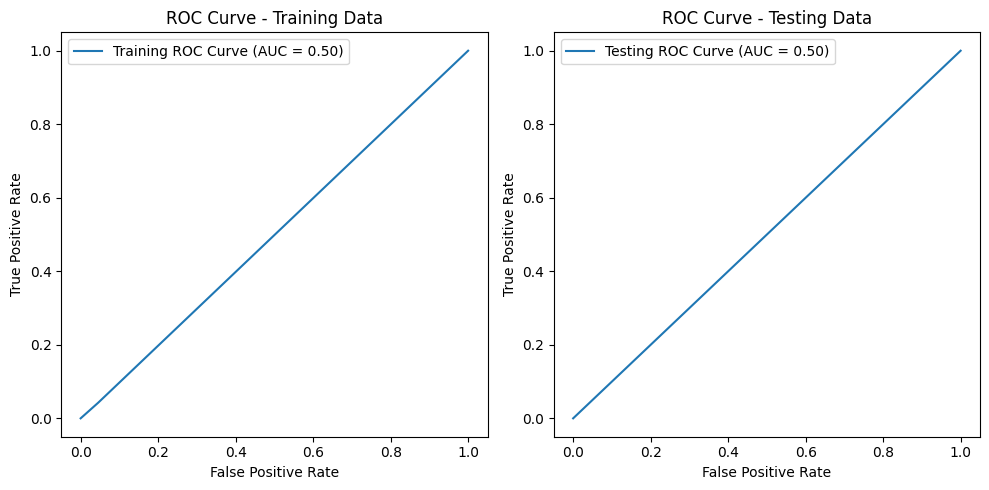

In [ ]:
# Hybrid model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, concatenate
from sklearn.metrics import roc_auc_score

# Encode labels
label_encoder = LabelEncoder()
training_labels_encoded = label_encoder.fit_transform(training_labels)
testing_labels_encoded = label_encoder.transform(testing_labels)
#validation_labels_encoded = label_encoder.transform(validation_labels)

# Combine the outputs of the CNN and LSTM models
cnn_output = cnn_model.output
lstm_output = lstm_model.output

# Add a fusion layer
fusion_layer = concatenate([cnn_output, lstm_output])
fusion_layer = Dense(128, activation='relu')(fusion_layer)  # Add a dense layer
fusion_layer = Dense(64, activation='relu')(fusion_layer)   # Add another dense layer

# Add a final output layer
output = Dense(1, activation='sigmoid')(fusion_layer)

# Create the hybrid model
hybrid_model = Model(inputs=[cnn_model.input, lstm_model.input], outputs=output)

# Compile the hybrid model
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the hybrid model with your actual data
print("-----------------------Hybrid Model Training--------------------------")
print("")
print("-----------------------Training Epoch Results--------------------------")
print("")
hybrid_model.fit([training_data, training_data], training_labels_encoded, epochs=3, batch_size=32, validation_split=0.2)
print("")
print("-----------------------Testing Epoch Results--------------------------")
print("")
hybrid_model.fit([testing_data, testing_data], testing_labels_encoded, epochs=3, batch_size=32, validation_split=0.2)
#print("")
#print("-----------------------Validation Epoch Results--------------------------")
#print("")
#hybrid_model.fit([validation_data, validation_data], validation_labels_encoded, epochs=5, batch_size=32, validation_split=0.2)

print("")
print("-----------------------Hybrid Model Evaluation--------------------------")
print("")
# Evaluate the hybrid model
training_loss, training_accuracy = hybrid_model.evaluate([training_data, training_data], training_labels_encoded)
_testing_loss, testing_accuracy = hybrid_model.evaluate([testing_data, testing_data], testing_labels_encoded)
#validation_loss, validation_accuracy = hybrid_model.evaluate([validation_data, validation_data], validation_labels_encoded)

training_hybrid_predictions = hybrid_model.predict([training_data, training_data])
training_hybrid_predictions = (training_hybrid_predictions > 0.5).astype(int)
testing_hybrid_predictions = hybrid_model.predict([testing_data,testing_data] )
testing_hybrid_predictions = (testing_hybrid_predictions > 0.5).astype(int)


# Calculate precision, recall, accuracy, and F1 score
training_precision = precision_score(training_labels_encoded, training_hybrid_predictions)
training_recall = recall_score(training_labels_encoded, training_hybrid_predictions)
training_accuracy = accuracy_score(training_labels_encoded, training_hybrid_predictions)
training_f1_score = f1_score(training_labels_encoded, training_hybrid_predictions)

testing_precision = precision_score(testing_labels_encoded, testing_hybrid_predictions)
testing_recall = recall_score(testing_labels_encoded, testing_hybrid_predictions)
testing_accuracy = accuracy_score(testing_labels_encoded, testing_hybrid_predictions)
testing_f1_score = f1_score(testing_labels_encoded, testing_hybrid_predictions)

print(f'Training Precision: {training_precision:.4f}')
print(f'Training Recall: {training_recall:.4f}')
print(f'Training Accuracy: {training_accuracy:.4f}')
print(f'Training F1 Score: {training_f1_score:.4f}')
print('---------------------------')
print(f'Testing Precision: {testing_precision:.4f}')
print(f'Testing Recall: {testing_recall:.4f}')
print(f'Testing Accuracy: {testing_accuracy:.4f}')
print(f'Testing F1 Score: {testing_f1_score:.4f}')

# Confusion Matrix
training_confusion_matrix = confusion_matrix(training_labels_encoded, training_hybrid_predictions)
testing_confusion_matrix = confusion_matrix(testing_labels_encoded, testing_hybrid_predictions)

print("")
print("Confusion Matrix for Training Data:")
print(training_confusion_matrix)
print("")
print("Confusion Matrix for Testing Data:")
print(testing_confusion_matrix)

# ROC Curve
training_roc_auc = roc_auc_score(training_labels_encoded, training_hybrid_predictions)
testing_roc_auc = roc_auc_score(testing_labels_encoded, testing_hybrid_predictions)

fpr_train, tpr_train, _ = roc_curve(training_labels_encoded, training_hybrid_predictions)
fpr_test, tpr_test, _ = roc_curve(testing_labels_encoded, testing_hybrid_predictions)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, label=f'Testing ROC Curve (AUC = {testing_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Data')
plt.legend()

plt.tight_layout()
plt.show()

# Display the Hybrid confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=testing_confusion_matrix, display_labels=np.unique(testing_labels_encoded))
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Hybrid Confusion Matrix")
plt.show()

Training Precision: 0.0699
Training Recall: 0.0427
Training Accuracy: 0.8870
Training F1 Score: 0.0530
---------------------------
Testing Precision: 0.5000
Testing Recall: 0.1509
Testing Accuracy: 0.7474
Testing F1 Score: 0.2318

Confusion Matrix for Training Data (Ensemble Model):
[[352468  16768]
 [ 28278   1260]]

Confusion Matrix for Testing Data (Ensemble Model):
[[10329   555]
 [ 3124   555]]


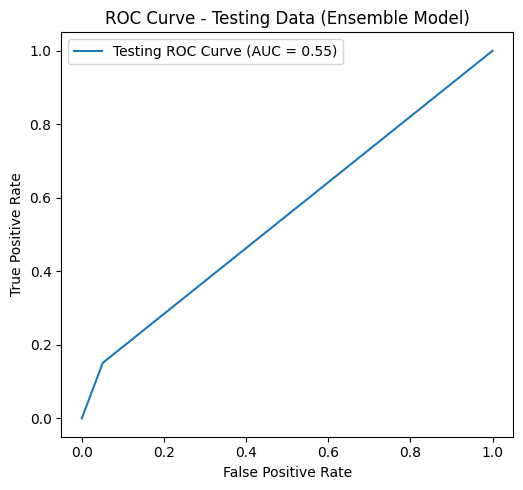

<Figure size 600x600 with 0 Axes>

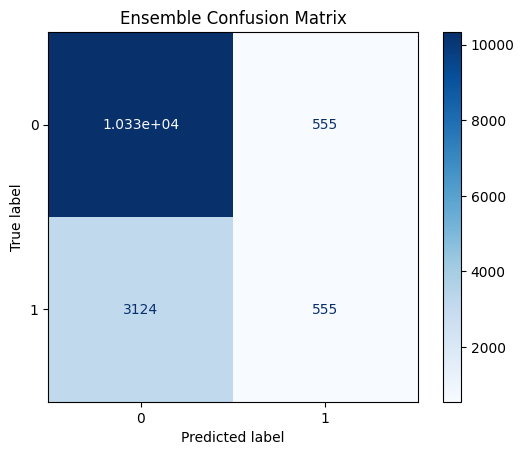

In [ ]:
#ensemble model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# Encode labels
label_encoder = LabelEncoder()
training_labels_encoded = label_encoder.fit_transform(training_labels)
testing_labels_encoded = label_encoder.transform(testing_labels)
#validation_labels_encoded = label_encoder.transform(validation_labels)

# Combine predictions by averaging (you can adjust the threshold)
training_ensemble_predictions = (training_cnn_predictions + training_lstm_predictions + training_hybrid_predictions) / 3
testing_ensemble_predictions = (testing_cnn_predictions + testing_lstm_predictions + testing_hybrid_predictions) / 3

# Threshold the ensemble predictions (you can adjust the threshold)
threshold = 0.3
training_ensemble_predictions = (training_ensemble_predictions > threshold).astype(int)
testing_ensemble_predictions = (testing_ensemble_predictions > threshold).astype(int)

# Calculate precision, recall, accuracy, and F1 score for the ensemble
training_precision = precision_score(training_labels_encoded, training_ensemble_predictions)
training_recall = recall_score(training_labels_encoded, training_ensemble_predictions)
training_accuracy = accuracy_score(training_labels_encoded, training_ensemble_predictions)
training_f1_score = f1_score(training_labels_encoded, training_ensemble_predictions)

testing_precision = precision_score(testing_labels_encoded, testing_ensemble_predictions)
testing_recall = recall_score(testing_labels_encoded, testing_ensemble_predictions)
testing_accuracy = accuracy_score(testing_labels_encoded, testing_ensemble_predictions)
testing_f1_score = f1_score(testing_labels_encoded, testing_ensemble_predictions)

print(f'Training Precision: {training_precision:.4f}')
print(f'Training Recall: {training_recall:.4f}')
print(f'Training Accuracy: {training_accuracy:.4f}')
print(f'Training F1 Score: {training_f1_score:.4f}')
print('---------------------------')
print(f'Testing Precision: {testing_precision:.4f}')
print(f'Testing Recall: {testing_recall:.4f}')
print(f'Testing Accuracy: {testing_accuracy:.4f}')
print(f'Testing F1 Score: {testing_f1_score:.4f}')

# Confusion Matrix for the ensemble model
training_ensemble_confusion_matrix = confusion_matrix(training_labels_encoded, training_ensemble_predictions)
testing_ensemble_confusion_matrix = confusion_matrix(testing_labels_encoded, testing_ensemble_predictions)

print("")
print("Confusion Matrix for Training Data (Ensemble Model):")
print(training_ensemble_confusion_matrix)
print("")
print("Confusion Matrix for Testing Data (Ensemble Model):")
print(testing_ensemble_confusion_matrix)

# ROC Curve for the ensemble model
training_ensemble_roc_auc = roc_auc_score(training_labels_encoded, training_ensemble_predictions)
testing_ensemble_roc_auc = roc_auc_score(testing_labels_encoded, testing_ensemble_predictions)

fpr_train_ensemble, tpr_train_ensemble, _ = roc_curve(training_labels_encoded, training_ensemble_predictions)
fpr_test_ensemble, tpr_test_ensemble, _ = roc_curve(testing_labels_encoded, testing_ensemble_predictions)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(fpr_test_ensemble, tpr_test_ensemble, label=f'Testing ROC Curve (AUC = {testing_ensemble_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Testing Data (Ensemble Model)')
plt.legend()

plt.tight_layout()
plt.show()


# Display the Ensemble confusion matrix
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=testing_ensemble_confusion_matrix, display_labels=np.unique(testing_labels_encoded))
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Ensemble Confusion Matrix")
plt.show()
